In [1]:
%matplotlib inline
#%matplotlib ipympl
%load_ext autoreload
%autoreload 2
from pylab import *
import pandas as pd


In [13]:
#Define a function to load the data
def load_data(start,end,ch,name="OKSeq",root="../data_hela/"):
    #Start and end are in kb
    #return x in kb and signalvalue
    
    data = {"OKSeq":"OKSeq_5kb.csv",
            "MRT":"MRT_10kb.csv",
            "Ori":"ori_position.tsv"}
    
    if "tsv" in data[name]:
        sep="\t"
    else:
        sep=","
    
    read = pd.read_csv(root+data[name],sep=sep)
    #print(read.head())
    
    read = read[read.chrom=="chr%i"%ch]
    read = read[ (start<read.chromStart/1000) &  (read.chromStart/1000< end)]
    return np.array(read.chromStart)/1000,np.array(read.signalValue)

# Simulation de reference

In [3]:
from repli1d.fast_sim_break import get_fast_MRT_RFDs

fork_speed= 1.5  # in kb / minute
ndiff=1.1  # Number of firing factors per Mb
Nsim = 200
binsize = 5 # in kb
dori = 10 # Average distance between origins in kb
noise_ratio = 0.1 # 10 percent of random activations 

startp=5000 # in kb
endp = 50000 # in kb
ch=1
genomic,DNase=load_data(startp,endp,ch=1,name="Ori")  #Generate random profile
RandomActivation = np.ones_like(DNase) * noise_ratio * np.sum(DNase) / len(DNase)  # Random activation
profile = DNase+RandomActivation


#Rescaling parameters to size of simulated chromosome
kon = 1e-5 * 2875000 / (len(DNase) * binsize ) #whole genome ( 2875000 == whole genome I am working with)
ndiff = int(ndiff * len(DNase) * binsize / 1000)
print("%.1e ,NDiff %i"%(kon,ndiff))

data = get_fast_MRT_RFDs(Nsim,
                         profile,
                         ndiff,
                         kon=kon,
                         fork_speed=fork_speed / binsize, #Fork speed is rescaled in bin/minute
                         single_mol_exp=True,
                         pulse_size=5,
                         dori=dori,
                         return_dict=True,n_jobs=6)

6.4e-04 ,NDiff 49
EXperimental
Fs cte , dt 3.3 (min)
Average introduced 0.0
Maxiiiiiiiiiiiiiii 126


# Simulation avec cascade

In [4]:
cascade = {"infl":50,
           "amount":100,
           "down":1,
          "damount":0.001}


data_cascade = get_fast_MRT_RFDs(200,
                         profile,
                         ndiff,
                         kon=kon,
                         fork_speed=fork_speed / binsize, #Fork speed is rescaled in bin/minute
                         single_mol_exp=True,
                         pulse_size=5,
                         dori=dori,
                         cascade=cascade,
                         return_dict=True,n_jobs=6)

EXperimental
Fs cte , dt 3.3 (min)
Average introduced 0.0
Maxiiiiiiiiiiiiiii 158


In [ ]:
# the cascade function is the followwing:

def comupute_enhanced(proba, actual_pos,cascade={}):

    #assert()

    infl = cascade["infl"] #,50)
    amount = cascade["amount"] #,4)
    down = cascade["down"]#,10)
    damount = cascade["damount"]#,1 / 10000.)

    cproba = np.zeros_like(proba) + 1
    for position, direction, init_position in actual_pos:
        # print(position,direction,cproba,max(position-infl),position)
        if direction == "L":
            cproba[position:min(position + infl, len(cproba) - 1)] *= amount
        if direction == "R":
            cproba[max(position - infl, 0):position] *= amount

        if direction == "L":
            cproba[position:min(position + down, len(cproba) - 1)] *= damount
        if direction == "R":
            cproba[max(position - down, 0):position] *= damount

    return cproba

# then the proba i use to draw the origin is the current proba * cproba

# you could replace by one of your own .
# by doing:

#from repli1d import fast_sim_break

#def custom_comupute_enhanced(proba, actual_pos,cascade={}):
#     blabla
#     return cproba

#fast_sim_break.compute_enhanced = your_own



# Single mol analysis

In [5]:
from repli1d.single_mol_analysis import compute_info, compute_real_inter_ori ,compute_mean_activated_ori

def compute_corre(datav,fiber_size=200): #fiber size in kb

    resolution = binsize
    Deltas0 = compute_info(Sme=datav["single_mol_exp"], size_single_mol=int(fiber_size/resolution), n_sample=500)

    print("Mean inter ori distance", np.mean(np.concatenate(Deltas0["dist_ori"])*resolution))

    Deltas = compute_real_inter_ori(datav["position_time_activated_oris"])
    print("Mean real inter ori distance", np.mean(Deltas)*resolution)

    nfork_per_fiber = np.array([len(di) for di in Deltas0["size_forks"]])
    # hist(nfork_per_fiber,range=[0,5],bins=6,normed=True)
    for i in range(5):
        print("Nfork %i, percent %.2f" % (i, np.sum(nfork_per_fiber == i)/len(nfork_per_fiber)))

    print("Mean number of fork / fiber having forks",
          np.mean(nfork_per_fiber[nfork_per_fiber != 0]))
    return Deltas0,Deltas
    
print("Without correlation\n")
Delta = compute_corre(data)

print("\nWith correlation\n")

Delta_corre = compute_corre(data_cascade)



Without correlation

Mean inter ori distance 87.9833836858006
Mean real inter ori distance 233.8429903125571
Nfork 0, percent 0.61
Nfork 1, percent 0.18
Nfork 2, percent 0.15
Nfork 3, percent 0.02
Nfork 4, percent 0.03
Mean number of fork / fiber having forks 1.8764493950693035

With correlation

Mean inter ori distance 45.784747527329515
Mean real inter ori distance 64.05875776664588
Nfork 0, percent 0.70
Nfork 1, percent 0.17
Nfork 2, percent 0.06
Nfork 3, percent 0.01
Nfork 4, percent 0.01
Mean number of fork / fiber having forks 2.8777227775245646


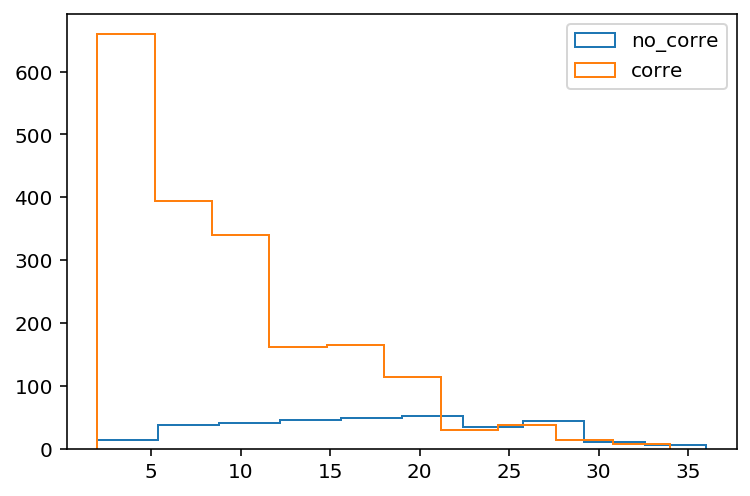

In [10]:
hist(np.concatenate(Delta[0]["dist_ori"]),histtype="step",label="no_corre");
hist(np.concatenate(Delta_corre[0]["dist_ori"]),histtype="step",label="corre");
legend()